In [10]:
import pandas as pd
import numpy as np
import requests
import json

import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import pickle
from pyvis import network as net


## Creation of DataFarme

In [146]:
#import given dataframe nodes
nodes = pd.read_csv("Data/nodes.csv")

nodes['author_id'] = None
nodes['cited_by'] = None 
nodes['interests'] = None
nodes.to_csv('Data/nodes.csv', index=False)

edges = pd.DataFrame(columns=['author1','author2']) 
edges.to_csv('Data/edges.csv', index=False)

# Parte 1
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.

# Parte 2
Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l'elenco dei suoi coautori utilizzando SerpAPI. Con tale elenco di nomi.

### a. Ottenere i coautori dei 7 autori principali
Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a ciascun nome nella lista di coautori. Per ogni risultato, salvare le informazioni come `name`, `affiliations`, `author_id`, `cited_by`, e `interests` in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

### b. Concatenazione dei DataFrame
Concatenare il DataFrame contenente le informazioni sui 7 autori principali con quello dei coautori generato al punto 2a in un unico DataFrame (è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id).

### c. Creazione del DataFrame delle Relazioni di Co-Authorship
Creare un terzo DataFrame con le colonne `author1` e `author2` che rappresenta le co-authorship. In questo DataFrame, una riga rappresenta un arco di coauthorship tra due autori. La co-authorship è binaria, non pesata.

### Risultati Finali
A questo punto, si avrannio due DataFrame:
- Uno contenente le informazioni relative agli autori (originali + i relativi coautori), con le colonne `name`, `affiliations`, `cited_by`, `interests`. Salvare come `nodes.csv` nella cartella `/data` tale DataFrame.
- Un altro per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori, con colonne `author1` e `author2`. Salvare come `edges.csv` nella cartella `/data` tale DataFrame.

In [153]:
#key in use right now
#apikey = "fdf699df4639eab63e1e575ad242554396d699b906617385aaf49afd4c8d8b4b"

In [154]:
#overwrite the row of nodes with df_update in the right position
#if the author given isn't in nodes, then it will get concatenated

def update_nodes(df_update):
    
    nodesMod = pd.read_csv(r'Data/nodes.csv') #read nodes.csv updated
    
    #check if the author is in nodes using attribute name as parameter
    if (nodesMod["name"] == df_update["name"][0]).any():
        #if author is already in nodesMod update the present row with df_update (may not be completed)
        for index in range(len(nodesMod)):
            #sroll down all the names in nodesMod and compare it with the df_update one
            if nodesMod["name"][index] == df_update["name"][0]:
                
                nodesMod.iloc[index]=df_update.iloc[0] #replace the row of nodesMod with df_update
                nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv with the one having the new row
    else:
        #if the author isn't already in nodes, concatenates it
        nodesMod = pd.concat([nodesMod, df_update], ignore_index=True)
        nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv by adding df_update at the end

In [155]:
# author_profile update nodes.csv with name, affiliations, author_id, cited_by, interests of a given author
# this function requires the name and affiliation of the author to search for and nodes (it contains only the original authors)

def author_profile(apiKey, name, affiliation):

    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given name
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }

    #save the request response in json
    response = requests.get(base_url, params=params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/" + name + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    notFound = True #used to see if among the profiles found there is one with the same name and affiliation as those given
    indexProfile = 0 #if correct profile is found, indexProfile change with the corresponding index, otherwise take profile 0

    #scroll through profiles to verifies if the profile found is the one that we are searching for and save the corrisponding index
    for index, profile in enumerate(results["profiles"]):
        if (name in profile["name"]):
            #setti l'indice solo se è la prima volta che entri se e gia cambiato non entri
            if indexProfile == 0:
                indexProfile = index
            if (affiliation in profile["affiliations"]):
                indexProfile = index #change the original index
                notFound = False #we have found the searched profile
                break #the desired profile has been found -> no need to continue
    
    interests = ' '  #set interest as "empty"
    prifileDesired = results["profiles"][indexProfile] #json with all the information of the profile

    authorId = prifileDesired["author_id"] 
    citedBy = prifileDesired["cited_by"]
        
    #not all profiles have the key 'interests' in the dict (coauthors)
    if 'interests' in prifileDesired:
        if prifileDesired["interests"] != '': #if key interest exist but it is empty 
            interests = ", ".join([i['title'] for i in prifileDesired["interests"]])  # select only titles for each interest, join to remove the square brackets (now seen as a single string instead of a list)
    else:
        #create a new key in the dict and set it as a empty string
        prifileDesired["interests"] = ' '
    
    #if we found the profile:
    if not notFound: 
        #create a new row of the dataframe with all the information needed and return it
        df_update = pd.DataFrame({'name': [name],'affiliations': [affiliation],'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update)
    
    #if there is no profile with the correct name and affiliation, we've taken the first one (we've already taken the necessary data)
    else:
        #create a new row of the dataframe with all the information needed and return it (affiliation is a string empty)
        df_update = pd.DataFrame({'name': [name],'affiliations': " ",'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update)

In [156]:
#get_profile_coauthors find all coauthors of the given author and save them in nodes and edges
#for every author check that the dict's key needed exist and if they are empty

def get_profile_coauthors(apiKey, authorID):
    
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }
    
    #save the request response in json
    response = requests.get(base_url, params = params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/"+authorID + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    edges = pd.read_csv(r'Data/edges.csv')  #read edges.csv
    
    authorName = results["author"] #saves the name of the author given as input with the Id
    
    for coauthor in results['co_authors']:  #for each coauthor
        
        #create a couples author-coauthor in both ways (used to check if it is already present in edges.csv)
        edgesCopules = [(authorName["name"], coauthor['name']), (coauthor['name'], authorName["name"])]
        
        notFound = True #the couple isn't already present
        
        #cycles through edges.csv and check if the pair to insert, edgesCopules, is already present (in both directions)
        for index, row in edges.iterrows():
            if (row['author1'], row['author2']) in edgesCopules or (row['author2'], row['author1']) in edgesCopules:
                #there is already a link between author and coauthor or vice versa
                notFound = False #the couple is present
        
        #if the pair is not present it is concatenated to edegs.csv
        if(notFound):
            row_edge = pd.DataFrame([{'author1' : authorName["name"], 'author2': coauthor['name']}])
            edges = pd.concat([edges, row_edge], ignore_index=True)

        #add a coauthor to nodes:
        #check if 'affiliations' is a key on the coauthor dict:
        if 'affiliations' in coauthor:
            if coauthor['affiliations'] == '': #check if affiliation is empty
                author_profile(apiKey, coauthor['name'], '') #calls author_profile with the name of the co-author and empty affiliation
            else:
                author_profile(apiKey, coauthor['name'], coauthor['affiliations'])#calls author_profile with the name and affiliation
                
        #if the coauthor's dict hasn't 'affiliations' key create it and calls author_profile
        else:
            coauthor['affiliations'] = " "
            author_profile(apiKey, coauthor['name'], coauthor['affiliations'])
    
    #when all coauthors of the main author have been insert in nodes and concatenated into edges (if not already present), overwrites edges 
    edges.to_csv(r'Data/edges.csv', index=False)

## Main Parte 1 & 2

In [152]:
#executes PART 1, creates the dataset with all information on the 7 original authors
#read the original nodes
nodes = pd.read_csv(r'Data/nodes.csv')

#iterate the row of the given df, for each one makes the call to the author_profile
for index, row in nodes.iterrows():
    author_profile(apikey, row['name'], row['affiliations'])


#run PART 2, add co-authors to nodes and create edges
#read nodes.csv (!!should only contain the names and affiliations of the 7 original authors)
nodes = pd.read_csv(r'Data/nodes.csv') 

#cycle the authors and takes their coauthors (and their required information), adds them to nodes and to edges with the relevant arch
for author in nodes["author_id"]:
    get_profile_coauthors(apikey, author)

# Parte 3
Usare il due dataset per creare grafico indiretto:
- a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
- b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. 
 Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.

In [171]:
#color_nodes takes a graph (G) as input, calculates the degree of all nodes and assigns a specific color to each one based on its degree. The results are returned in a dictionary where each node is associated with its corresponding colour.
def color_nodes(G):

    degrees = dict(G.degree()) # Calculate the degrees of nodes in the graph
    
    specific_colors = {} # Dictionary to store specific colors associated with nodes based on their degrees
    
    # Loop through nodes and their degrees
    for node, degree in degrees.items():
        if degree == 1:
            # Assign gray color to nodes with a degree of 1
            specific_colors[node] = '#C4C4C4'
        elif degree in range(2, 10):
            # Assign blue color to nodes with degrees from 2 to 9
            specific_colors[node] = '#1F51FF'
        elif degree in range(11, 20):
            # Assign purple color to nodes with degrees from 11 to 19
            specific_colors[node] = '#6C3483'
        elif degree:
            # Assign yellow color to nodes with degrees greater than 20
            specific_colors[node] = '#F4D03F'
            
    return specific_colors # Return the dictionary of nodes mapped to their specific colors


#visualize_graph takes graphData that contains graph and node colors, and uses these data to draw the graph coloring nodes based on the values
def visualize_graph(graphData):

    plt.figure(3, figsize=(12, 12))
    plt.title("Undirected Graph of Authors-Coauthors ") 
    
    pos = nx.kamada_kawai_layout(graphData[0])

    nx.draw(graphData[0], 
            with_labels=True, 
            node_color=graphData[1].values(), # Node colors based on the values in the provided dictionary
            node_size=200, 
            font_weight='bold',
            font_size=10,
            pos = pos)


#create_undirected_graph creates an empty undirected graph, adds nodes and edges to the graph (reading them from CSV files), assigns colors to nodes by invoking color_nodes() and returns the graph and a dictionary mapping nodes to their corresponding colors
def create_undirected_graph():
    # Creating an empty graph
    G = nx.Graph()
    
    # Read nodes and edges from CSV files
    nodes = pd.read_csv('Data/nodes.csv')
    edges = pd.read_csv('Data/edges.csv')

    # Add nodes to the graph with their attribute
    for index, row in nodes.iterrows():
        G.add_node(row['name'], affiliations=row['affiliations'], author_id=row['author_id'], cited_by=row['cited_by'], interests = row['interests'])

    # Add edges to the graph
    edges = edges[['author1', 'author2']].values.tolist()
    G.add_edges_from(edges)
    
    colorNodes = color_nodes(G) # Assign colors to nodes using color_nodes()

    # Return the graph and a dictionary mapping nodes to their corresponding colors
    return G, colorNodes


#create_interactive_graph saves an interactive graph (HTML and pdf) and save it along with its data. It takes as input graphID (if equal to 1, it saves the first_graph; otherwise, it saves the extended_graph) and graphData (containing the graph and a dictionary with node colors)
def create_interactive_graph(graphID, graphData):
    # Initialize the Network object
    nt = net.Network(height="800px",
                     width="100%",
                     bgcolor="#787878",
                     font_color="white")
    
    #convert the given NetworkX graph into the Network object
    nt.barnes_hut() # use Barnes-Hut algorithm
    nt.from_nx(graphData[0]) # create the graph from the NetworkX graph

    degree_dict = nx.degree(graphData[0]) #calculate node degrees to draw them proportionally 

    #assign node size and color based on degree and color information
    for node in nt.nodes:
        node['color'] = graphData[1][node['id']] #set node color
        
        #set node size and font size based on node degree
        if degree_dict[node['id']] == 1:
            node['size'] = 28
            node["font"]={"size": 50}
        elif degree_dict[node['id']] in range(2,5):
            node['size'] = degree_dict[node['id']]*18
            node["font"]={"size": degree_dict[node['id']]*28}
        else: 
            node['size'] = degree_dict[node['id']]*8
            node["font"]={"size": degree_dict[node['id']]*9}
            
    
    #save graph visualization, PDF, and pickled graph data based on graphID
    if graphID == 1:
        plt.savefig("visualizations/first_graph.pdf")
        nt.save_graph("visualizations/interactive_first_graph.html")

        with open("graphs/coauthorship_graph.gpickle", "wb") as file:
            pickle.dump(graphData[0], file)
    else:
        # Save visualization and data for the extended graph
        plt.savefig("visualizations/extended_graph.pdf")
        nt.save_graph("visualizations/interactive_extended_graph.html")
        with open("graphs/extended_coauthorship_graph.gpickle", "wb") as file:
            pickle.dump(graphData[0], file)

## Main Parte 3

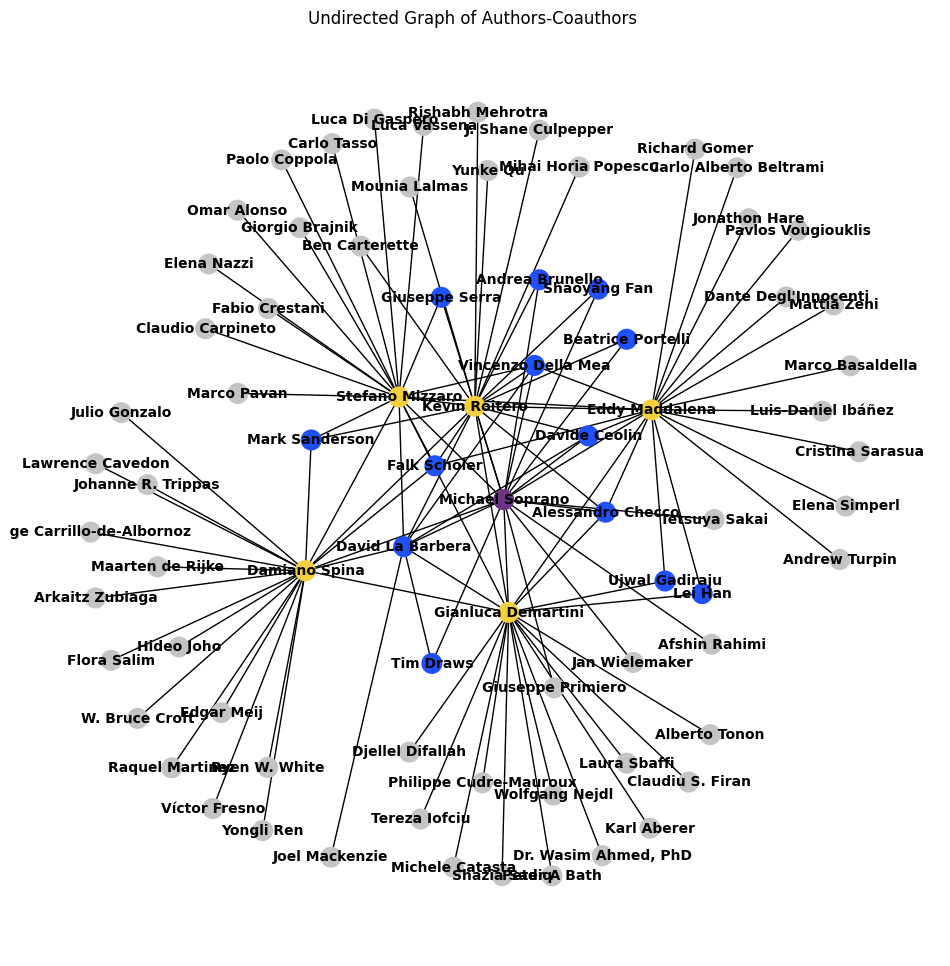

In [172]:
firstGraphData = create_undirected_graph() #generate undirected graph data

visualize_graph(firstGraphData) #visualize the undirected graph

create_interactive_graph(1, firstGraphData) #create and save an interactive graph for the first graph

# Parte 4
A partire dal grafo della Parte 3, 
- a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di
archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.
- b. Visualizzare e salvare il nuovo grafo.

In [173]:
#preferential_attachment_top_n_edges takes G and n. It calculates the preferential attachment of the graph G, generated at point 3, sorting the edges based on the probability of creation, and returning the top n edges with high probabilities. The resulting list contains pairs of nodes corresponding to the selected edges.
def preferential_attachment_top_n_edges(G, n):
    
    preferentialAttachment = nx.preferential_attachment(G) #calculate preferential attachment
    #sort the edges based on the probability of creation in descending order
    sortedEdges = sorted(preferentialAttachment, key=lambda x: x[2], reverse=True) 
    
    topEdges = sortedEdges[:n] #extract the top n edges with high probabilities of creation
    topEdges = [(x[0], x[1]) for x in topEdges] #create a list of node pairs for the selected edges

    return topEdges

# extended_graph_preferential_attachment takes a graph G as input.It add 50 edges based on preferential attachment, colors the nodes, and returns the updated graph and node colors (it gets saved as HTML and PDF)
def extended_graph_preferential_attachment(G):
    #save the edges created by preferential_attachment_top_n_edges
    preferentialAttachmentEdges = preferential_attachment_top_n_edges(G, 50)
    G.add_edges_from(preferentialAttachmentEdges) #add edges to the graph
    nodeColors = color_nodes(G) #color nodes and draw the graph
    
    return G , nodeColors

## Main parte 4

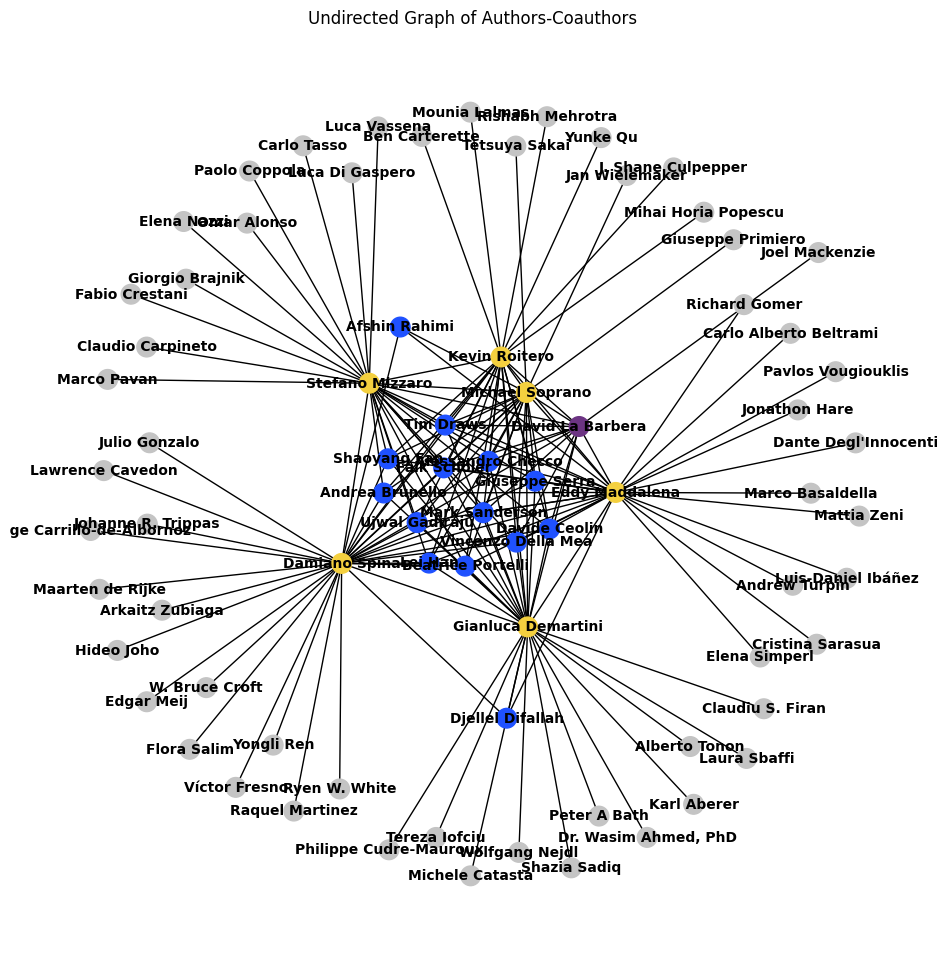

In [174]:
#add edges based on preferential attachment on first_graph
extendedGraphData = extended_graph_preferential_attachment(firstGraphData[0])

visualize_graph(extendedGraphData) #visualize the extended graph

create_interactive_graph(2,extendedGraphData) #create and save an interactive graph for the extended graph

## Es 5
Per entrambi i grafi prodotti calcolare:
1. Coefficiente di clustering medio
2. Centro del grafo
3. Raggio
4. Distanza Media
5. Transitività
6. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
7. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni  relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [184]:
#  Calculate the requested measures for the graph and save it in a dictionary
def calculateMeasureGraph(G, graph_name):
    graph_measure =pd.DataFrame({
    'Graph':graph_name,
    'Coefficienti di Clustering Medio': nx.average_clustering(G), #probabilità che i vicini di un nodo siano vicini tra loro
    'Centro del Grafo': [nx.center(G)], #torna una lista di nodi che hanno eccentricità pari al raggio
    'Raggio': nx.radius(G), #eccentricità minima
    'Distanza Media': nx.average_shortest_path_length(G), #lunghezza media del percorso più breve (c'è la formula sul sito di networkx)
    'Transitività': nx.transitivity(G), #frazione di tutti i possibili traingoli in G
    'Coefficiente Omega': nx.omega(G), #coefficiente di small-world (omega=Lr/L - C/Cl se negativo G è una grafo a reticolo se positivo G è un grafo casuale)
    'Coefficiente Sigma': nx.sigma(G) #coefficiente di small-world (sigma= C/Cr / L/Lr se sigma > 1 --> small world)
    #L=lunghezza media del percorso più breve C=coefficiente di clustering medio Lr=lunghezza media del percorso più breve in un grafo casuale equivalente Cl=coefficiente di clustering medio in un grafo a reticolo equivalente Cr=coefficiente di clustering medio di un grafo casuale equivalente
    })
    return graph_measure



# get the first graph
first_graph = firstGraphData[0]
first_graph_centralities=calculateMeasureGraph(first_graph, "first_graph")

# Generate the extended graph
graph_preferential_attachment=graphData2[0]
extended_graph_centralities=calculateMeasureGraph(graph_preferential_attachment, "graph_preferential_attachment")

# Part 7 concatanate the two dataFrame in a list save the dictionary in a csv
overall_measures = [first_graph_centralities,extended_graph_centralities]
overall_measures = pd.concat(overall_measures)
overall_measures.to_csv("results/overall_measures.csv", index=False)

## ES 6

#### Per entrambi i grafi prodotti calcolare per ogni nodo:
1. Degree Centrality
2. Betweenness Centrality
3. Closeness Centrality
4. Pagerank
5. HITS, per calcolare i valori di hubness e authority
6. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove
ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le
informazioni relative ad una misura calcolata per quel nodo. Salvare nella
cartella /results tali DataFrame.


In [186]:
#extract the hubness value from hits (hubness: nodi buoni collegati ad altri nodi importanti "però è grafo indiretto")
def hubness(G):
    hits_result=nx.hits(G)
    return hits_result[0]

#extract the authorities value from hits (authorities: nodi importanti "però è grafo indiretto")
def authorities(G):
    hits_result=nx.hits(G)
    return hits_result[1]

#  Calculate the requested measures for every node of the graph and save it in a dictionary
def calculateMeasureNode(G):
    Node_measure = pd.DataFrame (
        {'Node': list(G.nodes()),
         'Degree Centrality': list(nx.degree_centrality(G).values()),
         'Betweenness centrality': list(nx.betweenness_centrality(G).values()),
         'Closeness centrality': list(nx.closeness_centrality(G).values()),
         'PageRank': list(nx.pagerank(G).values()),
         'Hubness': list(hubness(G).values()),  # Hubness values
         'Authorities': list(authorities(G).values())  # Authorities values
         }
    )
    return Node_measure



#generate the two dataframe for the two graphthe results of the dataFrame
first_graph_centralities=calculateMeasureNode(first_graph)
extended_graph_centralities=calculateMeasureNode(graph_preferential_attachment)

#Part 6 generate the two csv to save the results of the dataFrame
first_graph_centralities.to_csv("results/first_graph_centralities.csv", index=False)
extended_graph_centralities.to_csv("results/extended_graph_centralities.csv", index=False)